In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [114]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, 100))

In [136]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        layers.append(nn.Linear(sizes[0] + 1, sizes[1]))
        if dropout:
            layers.append(nn.Dropout(dropout))
        layers.append(activation_fn)
        
        for i in range(1, len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, label):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(torch.cat((x, label.to(torch.float).view(label.shape[0], 1)), 1))

In [137]:
G = FullyConnected([prior_size, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [138]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [139]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [140]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z, label), label)
        true_pred = D(data, label)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z, label), label)
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [141]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(G(z, label), label)
            true_pred = D(data, label)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size
    
    for i in range(10):
        fixed_gen = G(fixed_z, i*torch.ones(fixed_z.shape[0])).data.numpy().reshape(10, 1, 28, 28)
        plot_mnist(fixed_gen, (1, 10), True)

#     fixed_gen = G(fixed_z).data.numpy().reshape(50, 1, 28, 28)
#     plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 4.2166, D: 0.1812
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 3.1986, D: 0.1929
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 2.6362, D: 0.1930


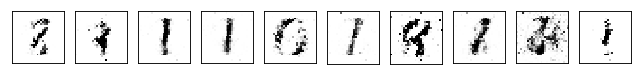

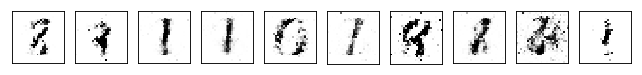

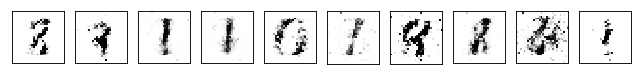

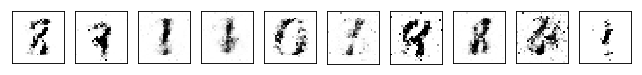

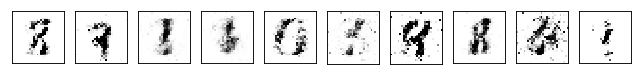

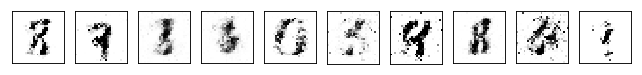

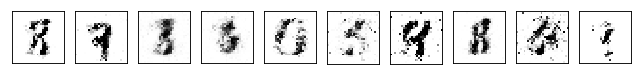

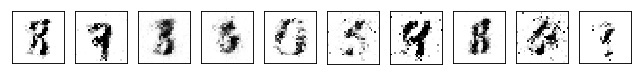

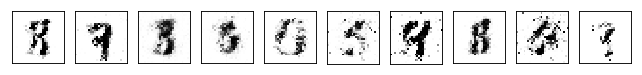

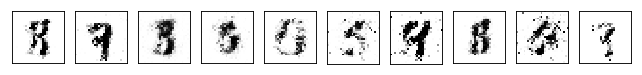

Test losses. G: 2.4067, D: 0.1039
Train Epoch: 2 [0/50000 (0%)]	Losses G: 3.2621, D: 0.1809
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 3.6248, D: 0.2095
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 3.7237, D: 0.1292


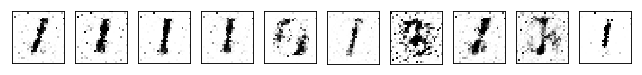

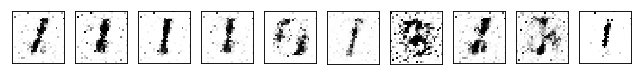

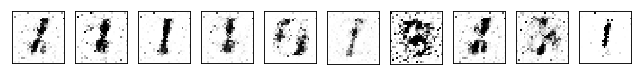

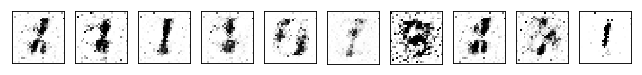

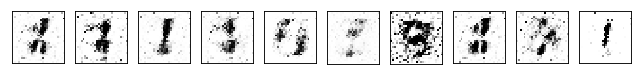

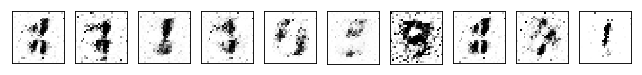

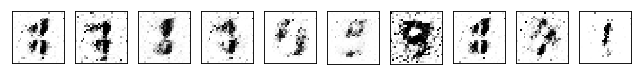

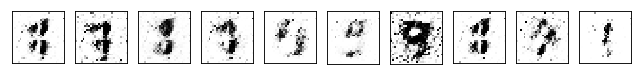

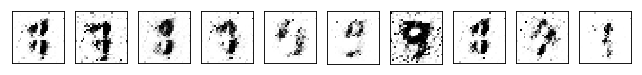

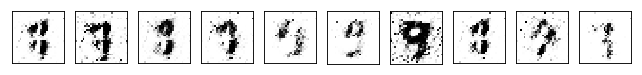

Test losses. G: 3.2727, D: 0.0603
Train Epoch: 3 [0/50000 (0%)]	Losses G: 3.9402, D: 0.0856
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 3.2326, D: 0.1766
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 3.3932, D: 0.2089


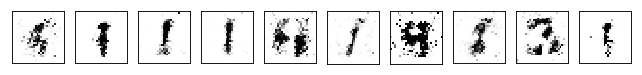

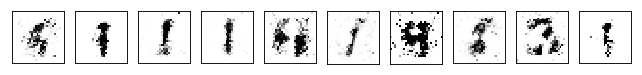

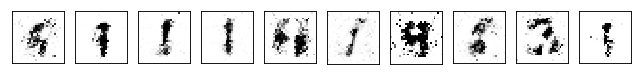

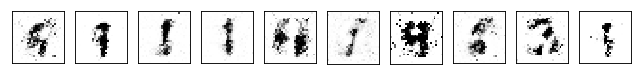

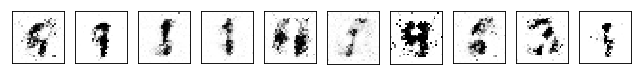

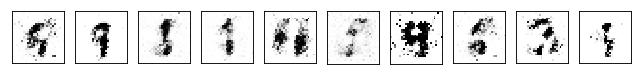

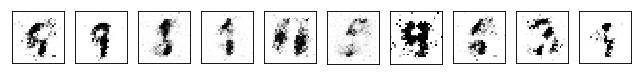

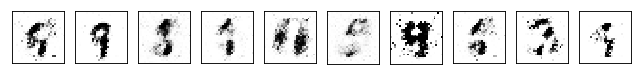

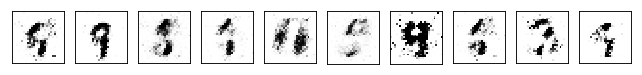

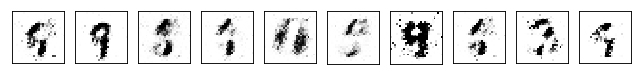

Test losses. G: 2.9824, D: 0.0981
Train Epoch: 4 [0/50000 (0%)]	Losses G: 3.7315, D: 0.1852
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 4.1710, D: 0.0884
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 3.4331, D: 0.1835


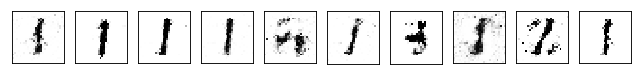

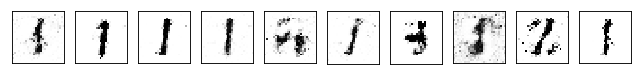

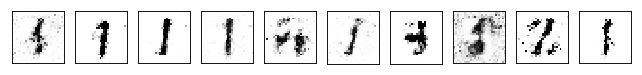

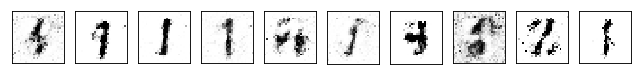

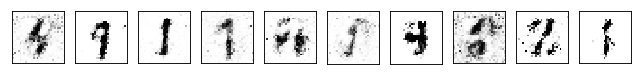

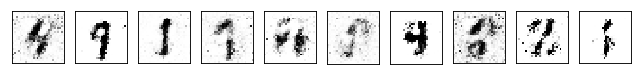

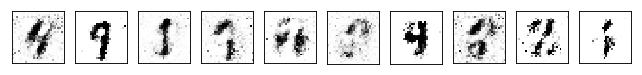

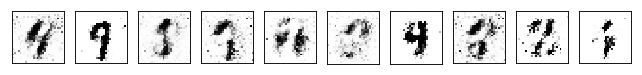

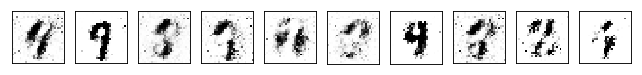

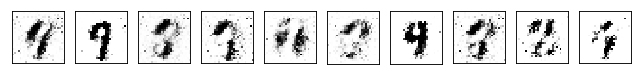

Test losses. G: 2.9069, D: 0.0889
Train Epoch: 5 [0/50000 (0%)]	Losses G: 4.3955, D: 0.2213
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 4.1241, D: 0.1539
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 3.1481, D: 0.2152


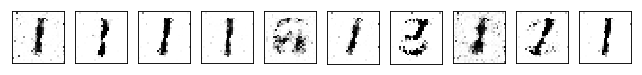

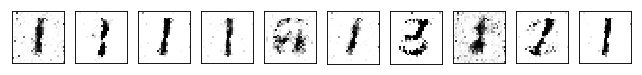

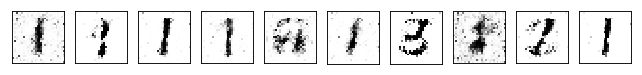

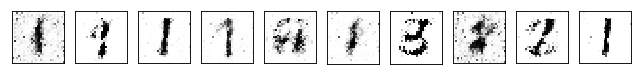

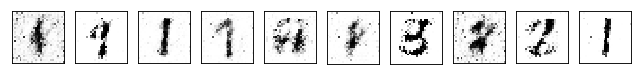

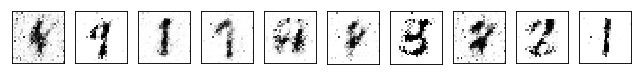

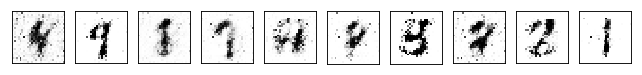

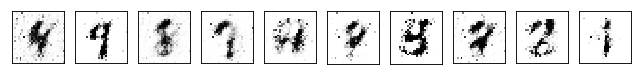

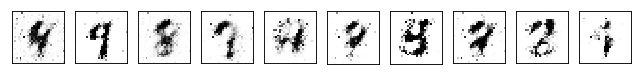

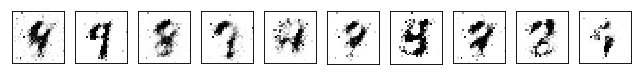

Test losses. G: 2.8865, D: 0.1016
Train Epoch: 6 [0/50000 (0%)]	Losses G: 3.5323, D: 0.1648
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 4.1252, D: 0.1650
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 3.0094, D: 0.3256


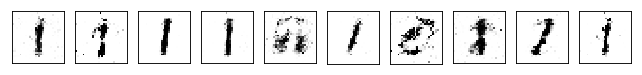

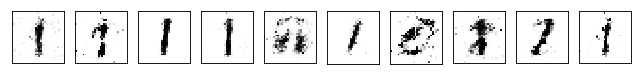

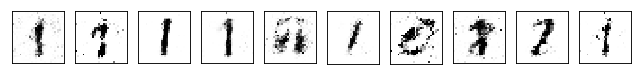

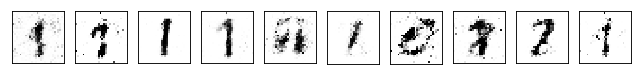

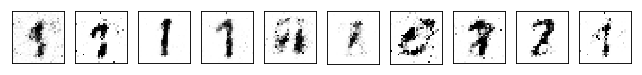

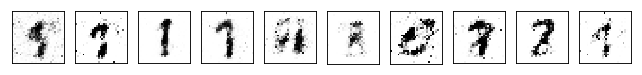

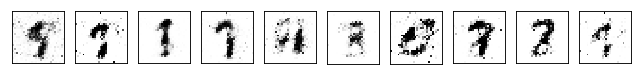

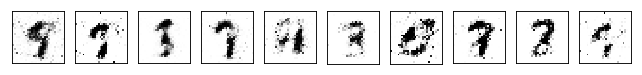

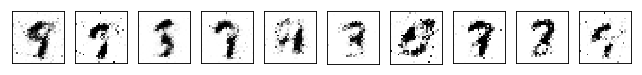

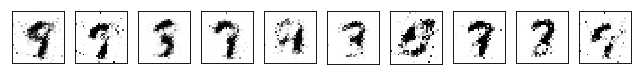

Test losses. G: 2.7713, D: 0.1560
Train Epoch: 7 [0/50000 (0%)]	Losses G: 3.1302, D: 0.2209
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 4.2563, D: 0.1238
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 3.6493, D: 0.1203


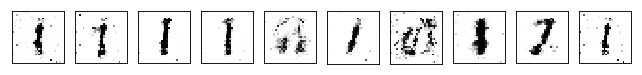

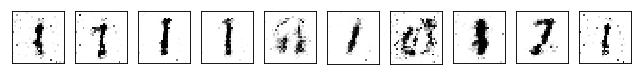

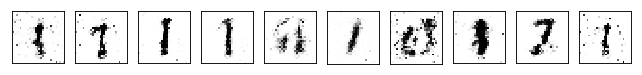

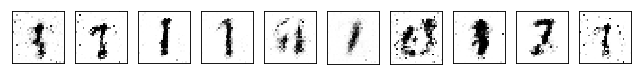

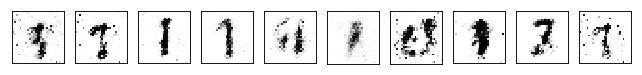

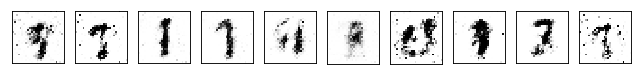

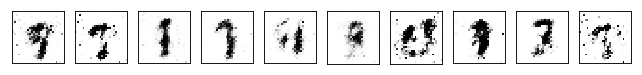

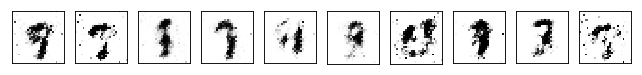

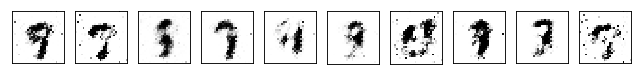

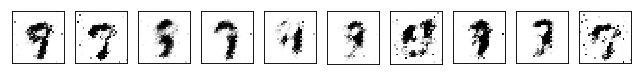

Test losses. G: 3.4100, D: 0.0755
Train Epoch: 8 [0/50000 (0%)]	Losses G: 3.6609, D: 0.1394
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 4.2072, D: 0.1470
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 2.5844, D: 0.1736


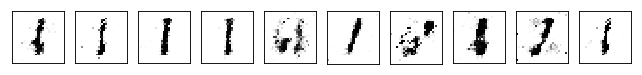

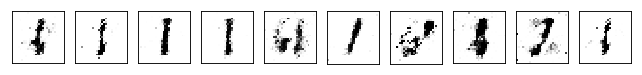

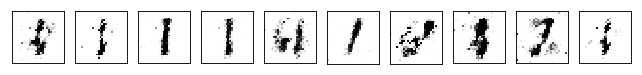

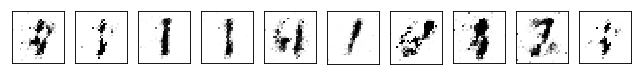

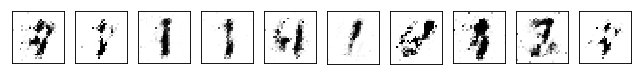

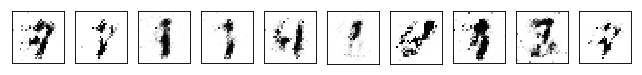

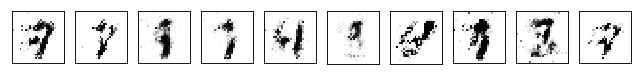

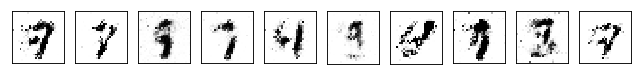

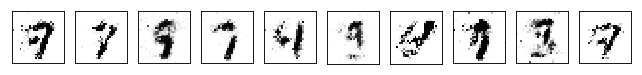

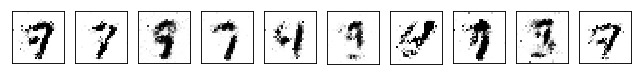

Test losses. G: 2.2831, D: 0.1299
Train Epoch: 9 [0/50000 (0%)]	Losses G: 2.7503, D: 0.1931
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 2.7659, D: 0.2276
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 3.1534, D: 0.1681


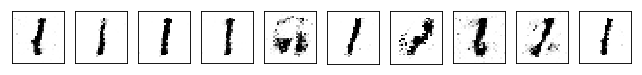

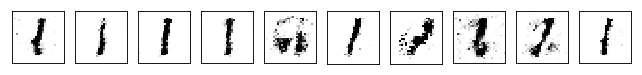

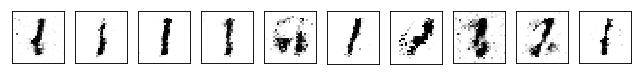

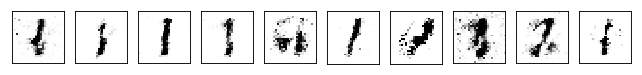

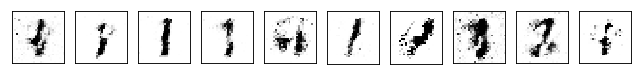

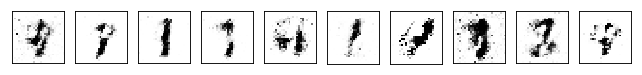

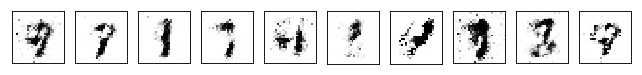

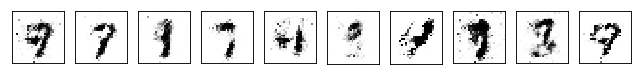

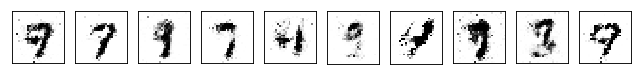

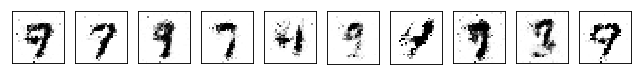

Test losses. G: 2.9018, D: 0.0902
Train Epoch: 10 [0/50000 (0%)]	Losses G: 2.8618, D: 0.1730
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 3.4807, D: 0.1316
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 2.9926, D: 0.1618


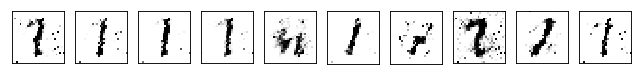

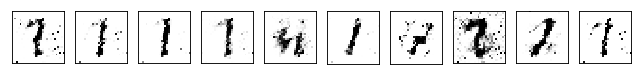

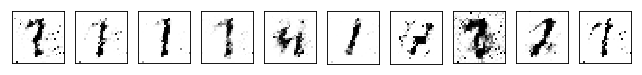

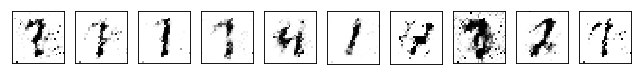

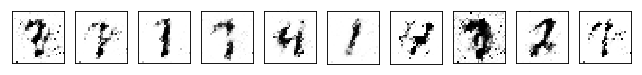

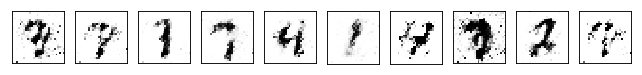

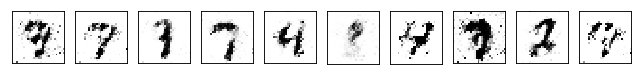

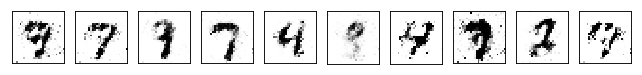

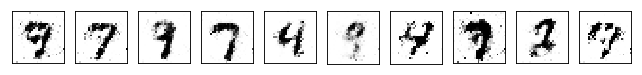

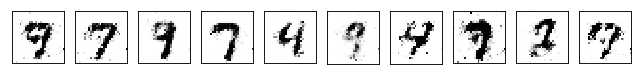

Test losses. G: 2.8498, D: 0.1111
Train Epoch: 11 [0/50000 (0%)]	Losses G: 3.2148, D: 0.2142
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 3.7925, D: 0.1866
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 2.7078, D: 0.2457


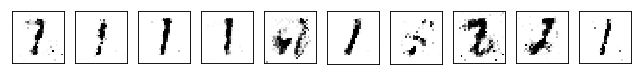

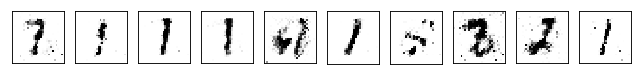

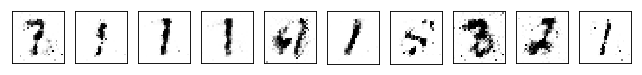

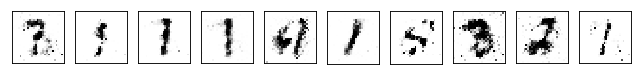

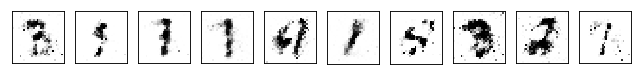

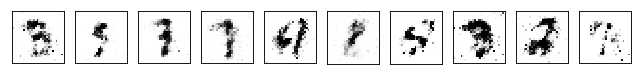

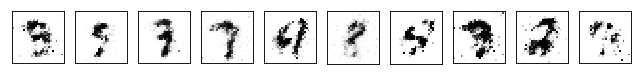

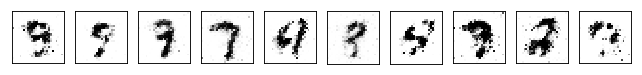

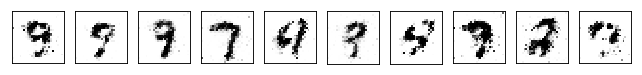

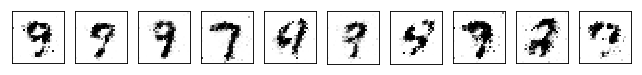

Test losses. G: 2.3370, D: 0.1550
Train Epoch: 12 [0/50000 (0%)]	Losses G: 2.8109, D: 0.3027
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 2.7553, D: 0.2354
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 3.2438, D: 0.2619


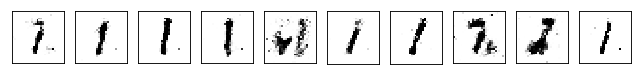

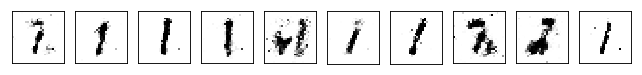

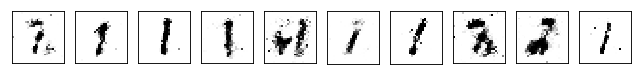

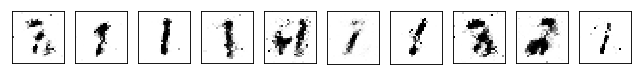

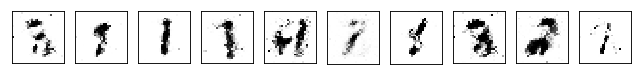

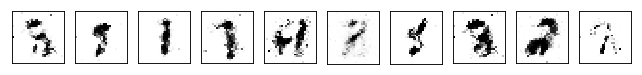

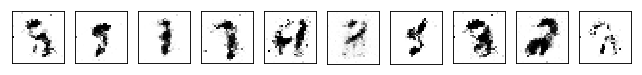

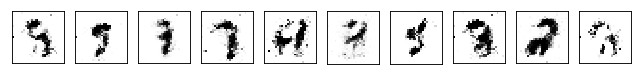

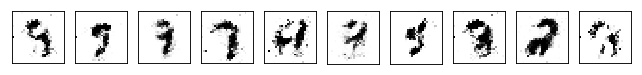

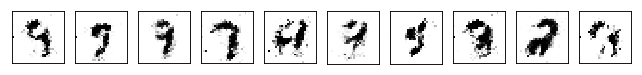

Test losses. G: 2.8824, D: 0.1467
Train Epoch: 13 [0/50000 (0%)]	Losses G: 2.6122, D: 0.2589
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 3.8949, D: 0.1619
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 2.7511, D: 0.2448


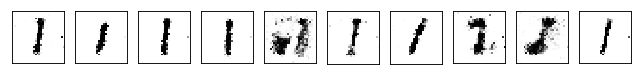

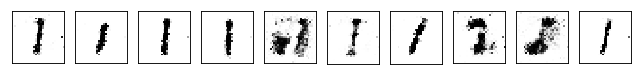

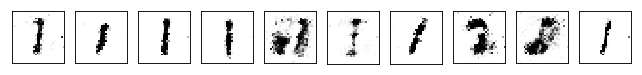

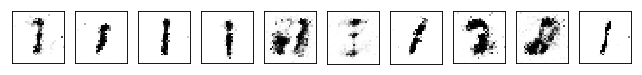

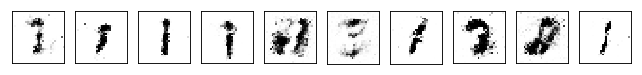

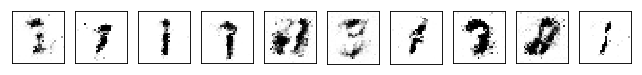

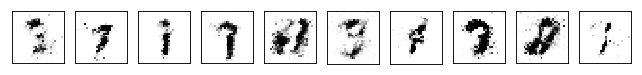

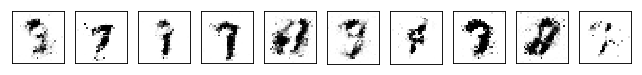

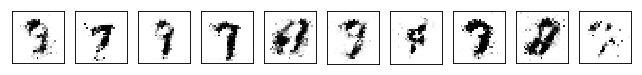

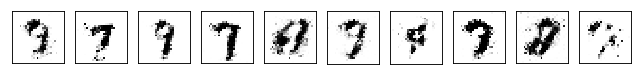

Test losses. G: 2.4110, D: 0.1413
Train Epoch: 14 [0/50000 (0%)]	Losses G: 3.1201, D: 0.1930
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 3.3762, D: 0.2463
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 2.7925, D: 0.2798


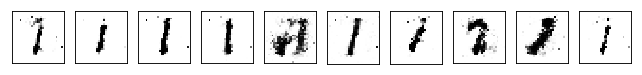

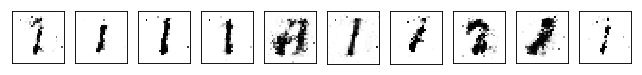

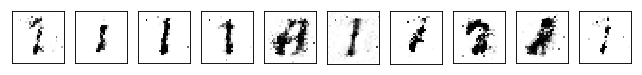

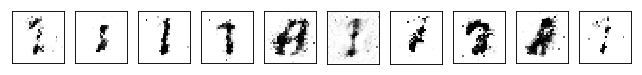

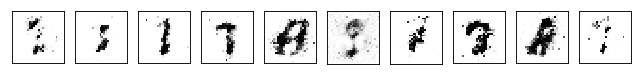

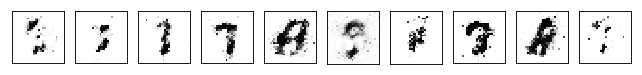

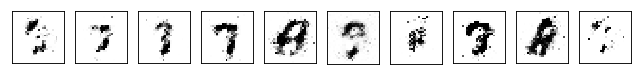

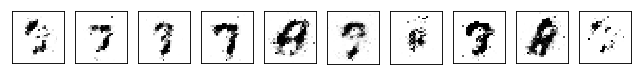

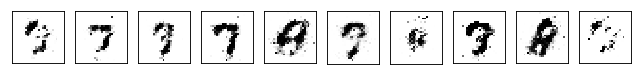

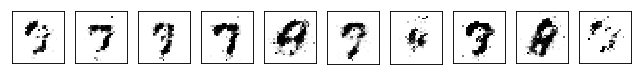

Test losses. G: 2.4951, D: 0.1584
Train Epoch: 15 [0/50000 (0%)]	Losses G: 2.2555, D: 0.2208
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 2.6680, D: 0.2180
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 3.6174, D: 0.2042


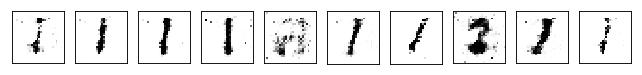

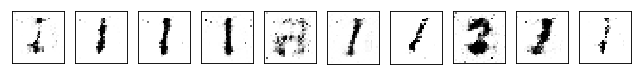

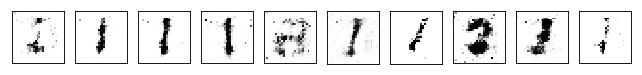

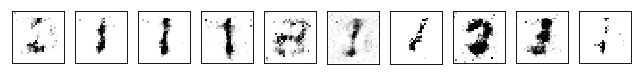

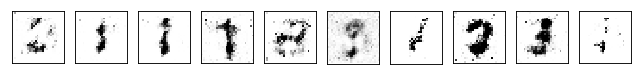

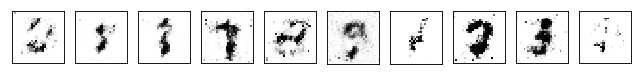

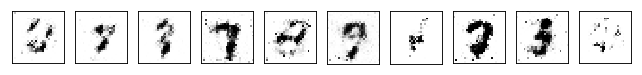

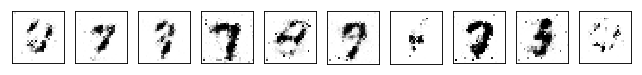

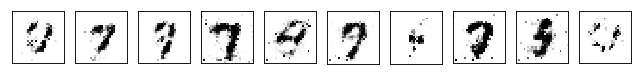

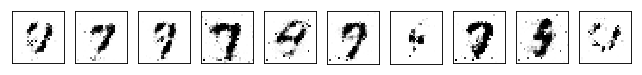

Test losses. G: 3.1953, D: 0.0997
Train Epoch: 16 [0/50000 (0%)]	Losses G: 3.1496, D: 0.1784
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 3.0135, D: 0.2516
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 3.3654, D: 0.1653


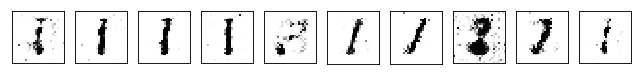

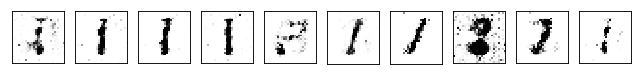

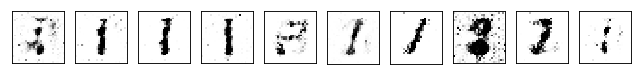

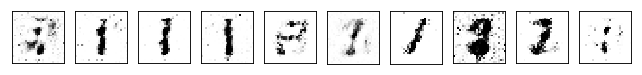

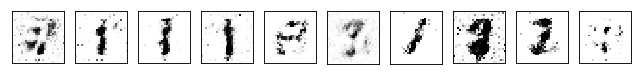

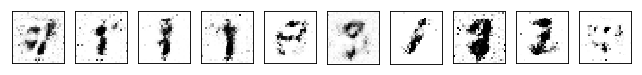

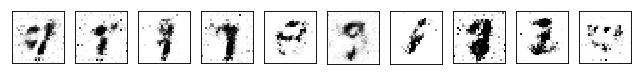

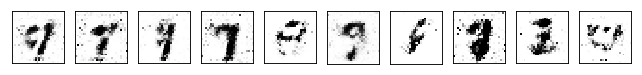

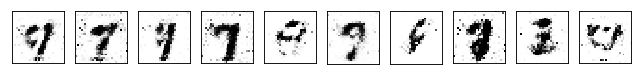

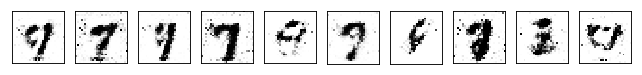

Test losses. G: 3.1040, D: 0.1211
Train Epoch: 17 [0/50000 (0%)]	Losses G: 3.2152, D: 0.1868
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 3.1377, D: 0.2334
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 3.0032, D: 0.2293


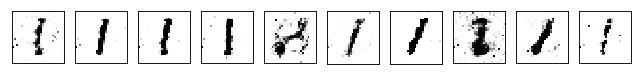

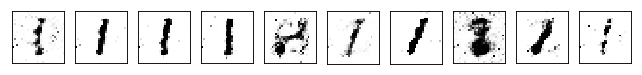

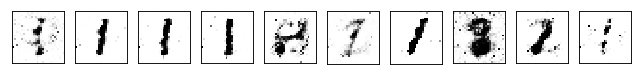

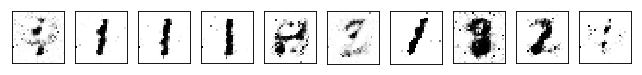

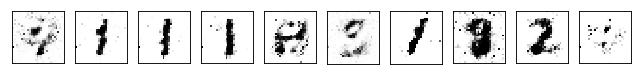

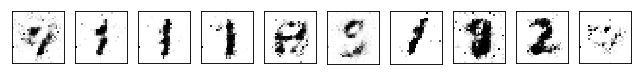

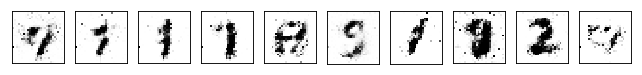

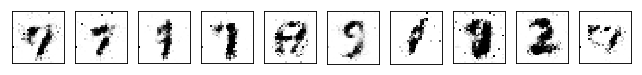

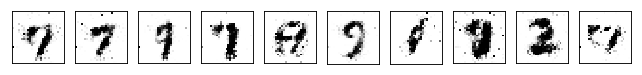

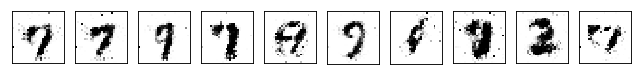

Test losses. G: 2.6439, D: 0.1704
Train Epoch: 18 [0/50000 (0%)]	Losses G: 2.9814, D: 0.2508
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 2.7567, D: 0.2280
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 2.4921, D: 0.2303


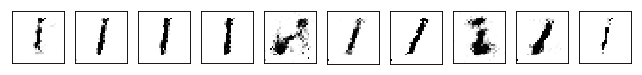

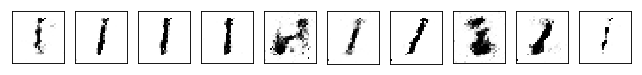

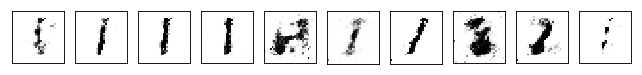

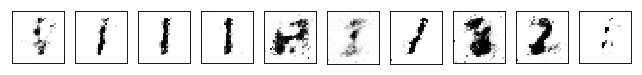

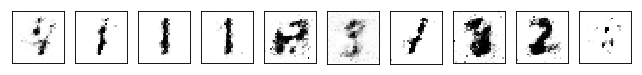

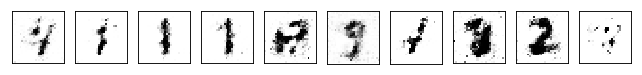

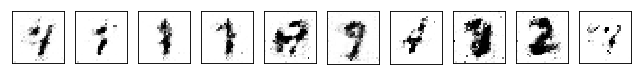

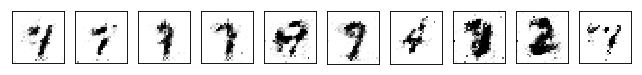

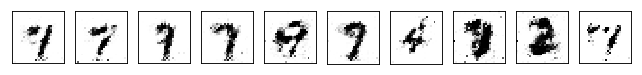

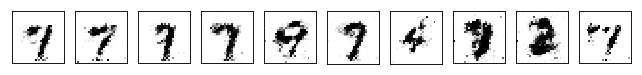

Test losses. G: 2.3317, D: 0.1705
Train Epoch: 19 [0/50000 (0%)]	Losses G: 2.6143, D: 0.2649
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 2.5686, D: 0.3215
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 3.6601, D: 0.2431


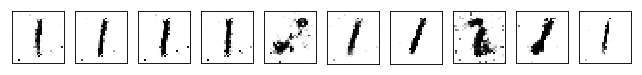

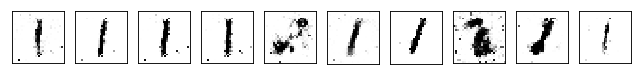

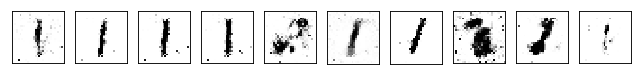

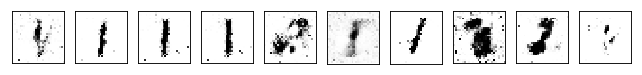

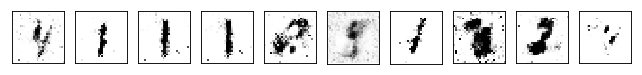

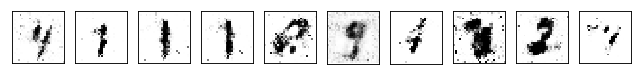

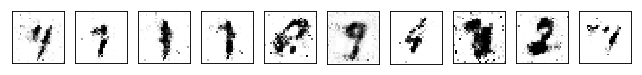

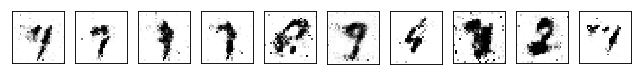

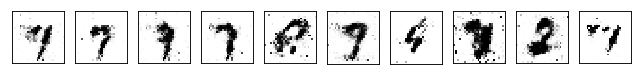

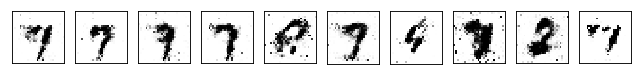

Test losses. G: 3.3354, D: 0.1574
Train Epoch: 20 [0/50000 (0%)]	Losses G: 2.7659, D: 0.2222
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 2.5924, D: 0.2825
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 3.2862, D: 0.1853


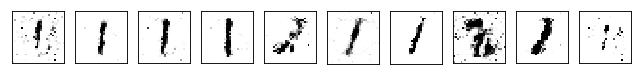

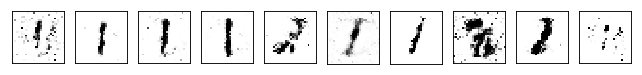

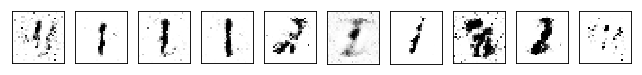

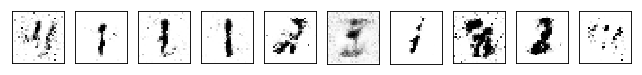

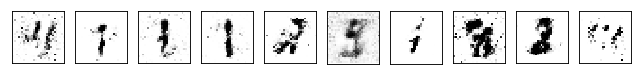

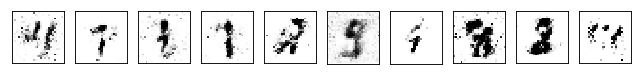

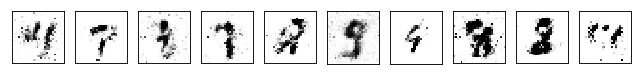

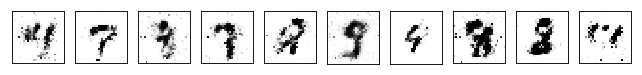

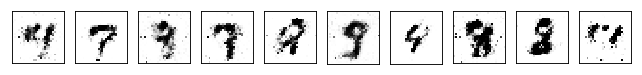

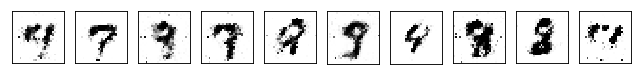

Test losses. G: 3.2703, D: 0.1473
Train Epoch: 21 [0/50000 (0%)]	Losses G: 3.7663, D: 0.2423
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 3.7122, D: 0.2592
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 2.8349, D: 0.2145


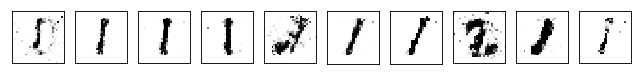

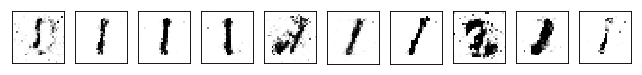

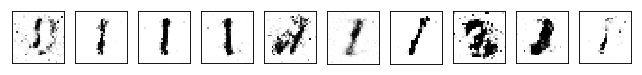

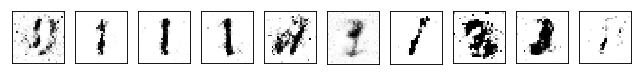

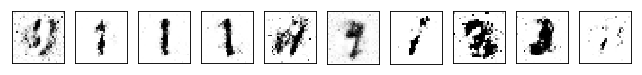

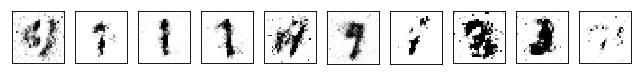

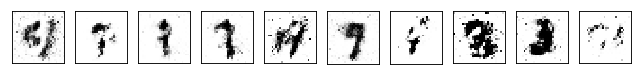

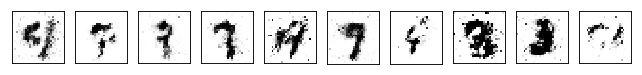

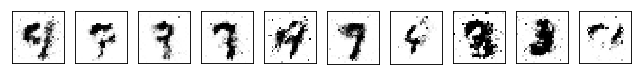

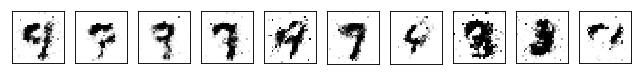

Test losses. G: 2.3802, D: 0.1841
Train Epoch: 22 [0/50000 (0%)]	Losses G: 2.7215, D: 0.2794
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 2.6837, D: 0.3025
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 2.7016, D: 0.3000


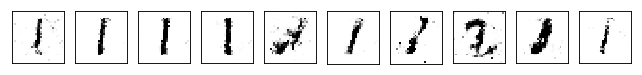

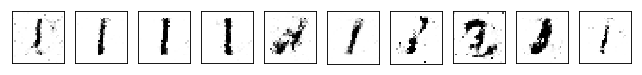

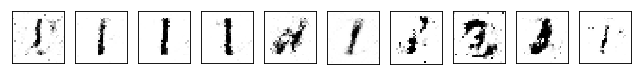

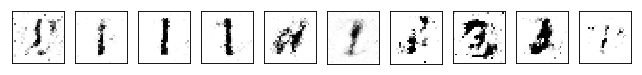

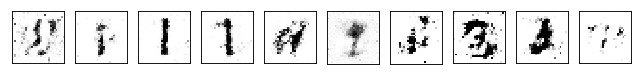

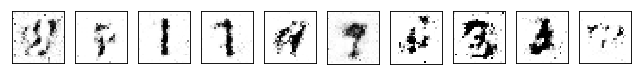

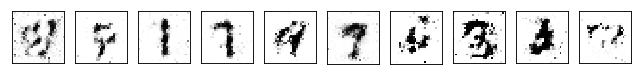

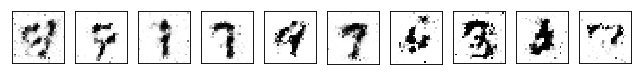

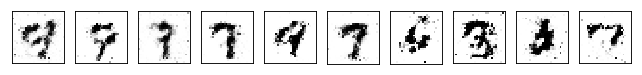

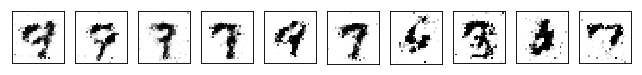

Test losses. G: 2.4728, D: 0.2190
Train Epoch: 23 [0/50000 (0%)]	Losses G: 2.7875, D: 0.2968
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 2.4836, D: 0.2930
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 3.1876, D: 0.2347


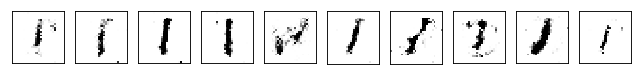

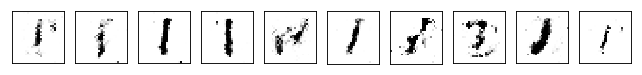

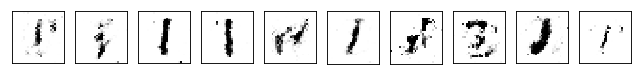

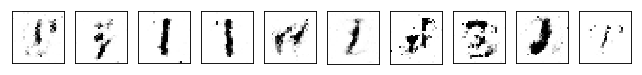

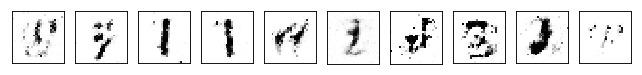

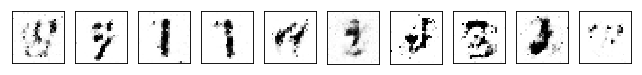

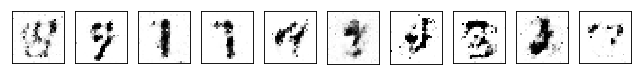

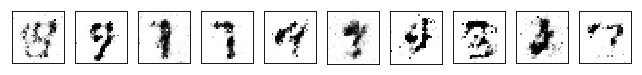

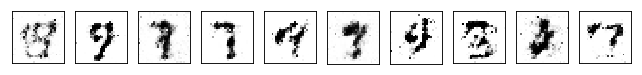

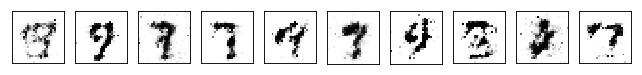

Test losses. G: 2.9854, D: 0.1655
Train Epoch: 24 [0/50000 (0%)]	Losses G: 3.1024, D: 0.2381
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 2.9777, D: 0.2372
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 2.2511, D: 0.3179


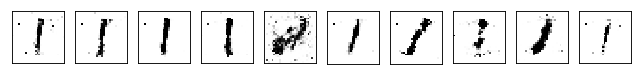

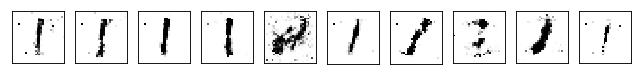

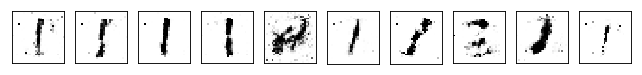

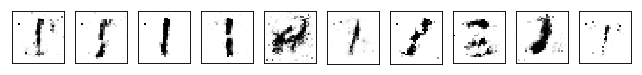

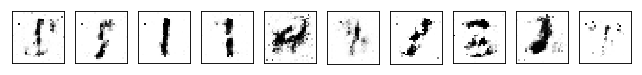

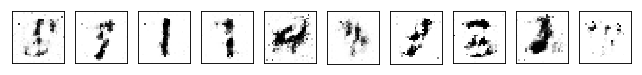

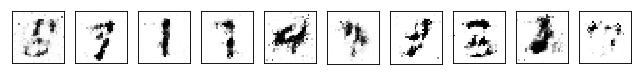

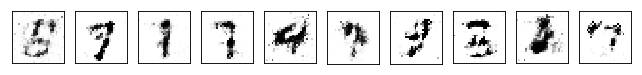

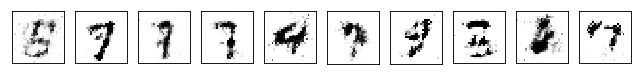

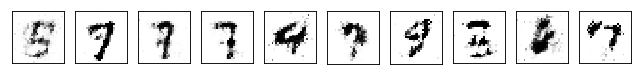

Test losses. G: 1.9763, D: 0.2353
Train Epoch: 25 [0/50000 (0%)]	Losses G: 2.0984, D: 0.2778
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 2.1723, D: 0.2739
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 2.8265, D: 0.2521


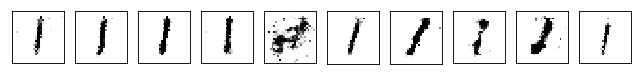

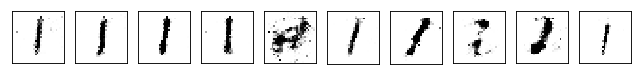

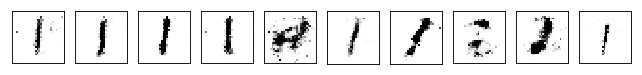

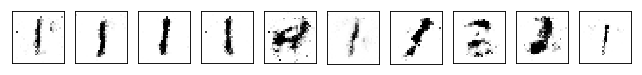

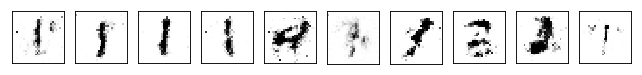

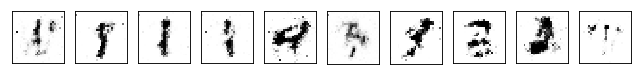

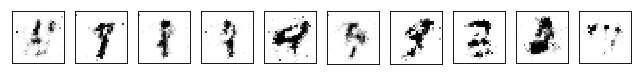

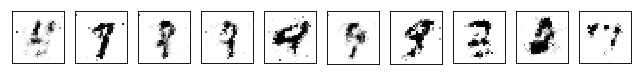

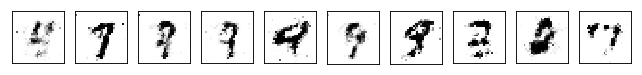

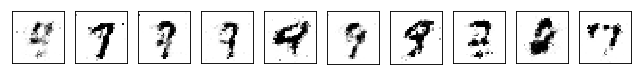

Test losses. G: 2.6706, D: 0.1936
Train Epoch: 26 [0/50000 (0%)]	Losses G: 3.0214, D: 0.2468
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 2.1684, D: 0.2910
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 2.2020, D: 0.2807


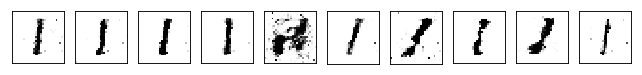

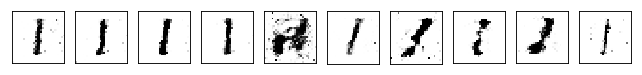

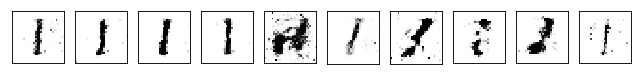

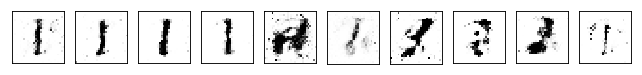

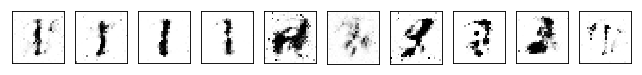

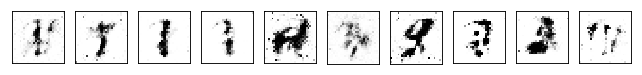

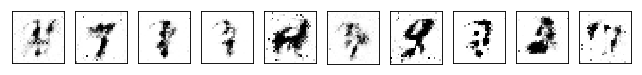

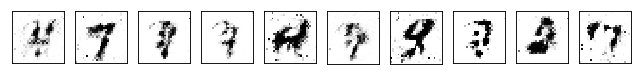

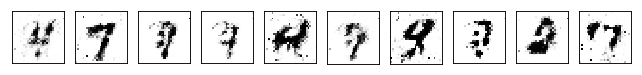

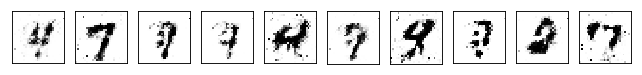

Test losses. G: 1.8851, D: 0.2407
Train Epoch: 27 [0/50000 (0%)]	Losses G: 2.4659, D: 0.2857
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 2.4131, D: 0.2528
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 2.5883, D: 0.2674


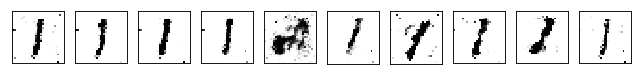

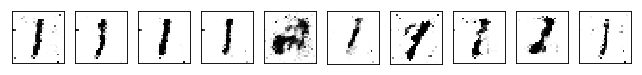

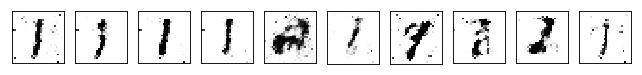

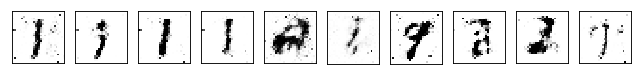

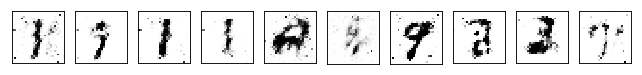

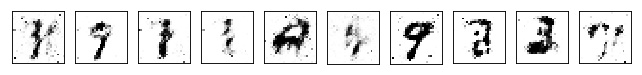

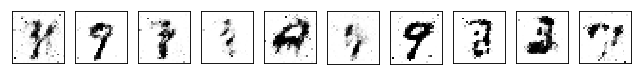

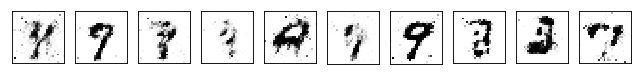

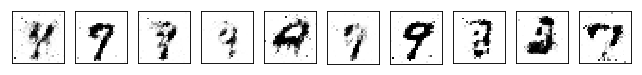

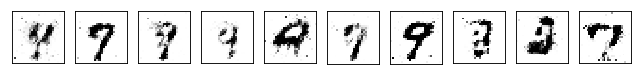

Test losses. G: 2.4077, D: 0.1670
Train Epoch: 28 [0/50000 (0%)]	Losses G: 2.5875, D: 0.2442
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 2.9340, D: 0.3028
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 1.9431, D: 0.2644


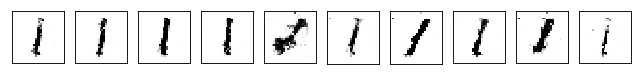

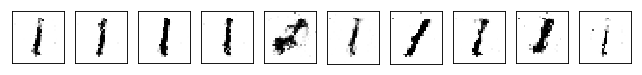

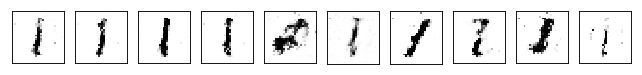

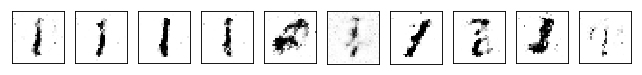

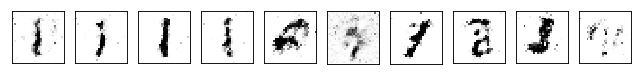

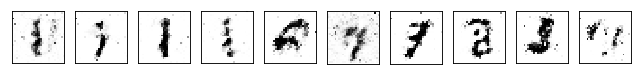

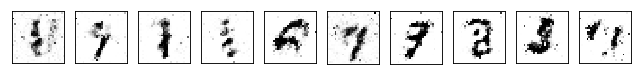

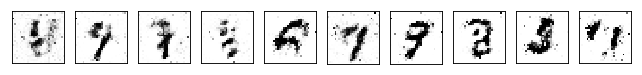

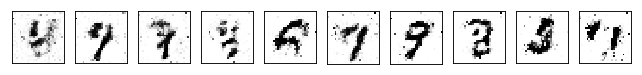

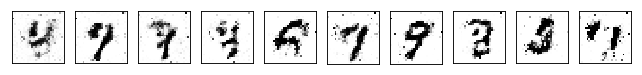

Test losses. G: 1.9745, D: 0.1904
Train Epoch: 29 [0/50000 (0%)]	Losses G: 2.2243, D: 0.2502
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 3.0659, D: 0.2163
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 2.9148, D: 0.2462


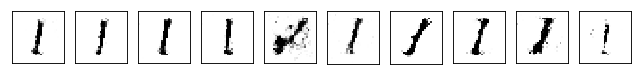

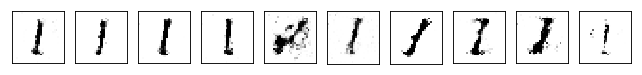

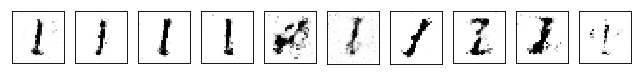

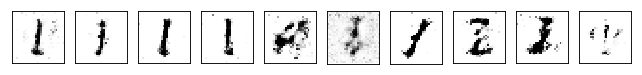

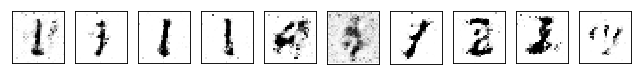

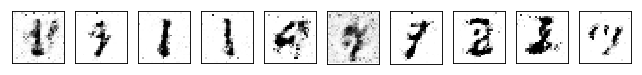

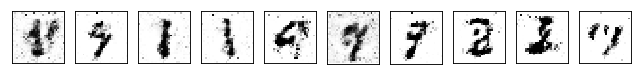

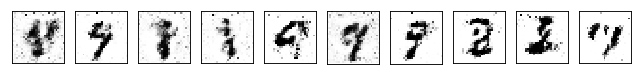

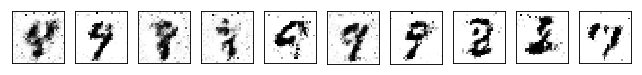

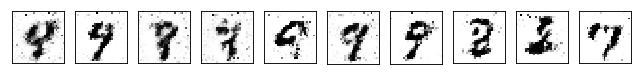

Test losses. G: 2.6932, D: 0.2111
Train Epoch: 30 [0/50000 (0%)]	Losses G: 2.5904, D: 0.2416
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 3.0166, D: 0.2783
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 2.6860, D: 0.3624


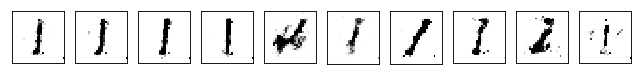

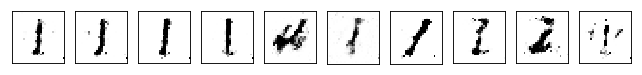

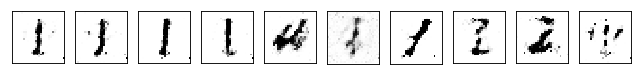

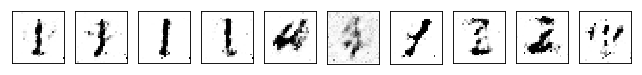

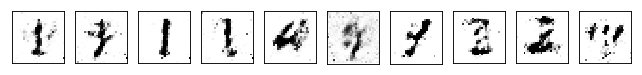

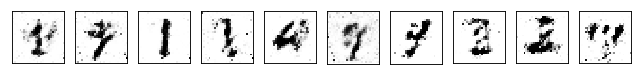

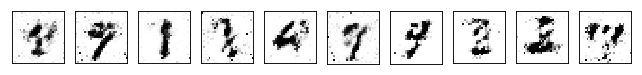

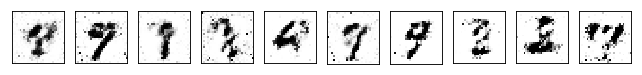

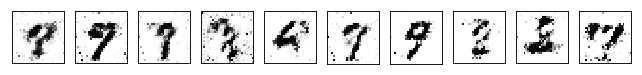

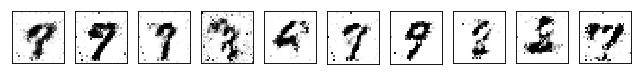

Test losses. G: 2.2906, D: 0.2239


In [143]:
for epoch in range(1, 31):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)